In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as cm
import datetime
from datetime import timedelta
from epiweeks import Week, Year
import seaborn as sns
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
data_file = "/project/biocomplexity/COVID-19_commons/products/external_data_collection/VDH_wastewater/VDH dashboard/VDH-UVA WWS viral load and trends[33].xlsx"
load_df = pd.read_excel(data_file,sheet_name='Region and Load')
trend_df = pd.read_excel(data_file,sheet_name='Trends')

# Rename columns
load_df.columns = ['Sewershed', 'VA Health Region', 'Attribute', 'Viral_Load']
load_df['Attribute'] = pd.to_datetime(load_df['Attribute'])

trend_df.columns = ['Sewershed', 'Attribute', 'Trends']
trend_df['Attribute'] = pd.to_datetime(trend_df['Attribute'])

# load sewershed to WWS
WWS_key = pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/county_mappings/sewershed_WWS_mapping.csv')

# load WWS to district mapping
district_key = pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/county_mappings/WWS_to_District.csv')

# isolation WWS ares to district with highest fraction
# NOTE: could sum the fractions for each trend in each district and use the highest fraction for the trend for that district
district_key_top = district_key.sort_values('Fraction', ascending=False).drop_duplicates('WWS').sort_index()

In [13]:
# Pull in raw hospitalization data by county
county_hosp_data_raw = pd.read_csv('/project/biocomplexity/COVID-19_commons/data/COVIDCast/dsew-cpr_confirmed_admissions_covid_1d_7dav_county.csv',parse_dates=['time_value','issue'],dtype={'geo_value':str})
county_hosp_data_raw = county_hosp_data_raw[['geo_value', 'time_value', 'issue', 'value']]
county_hosp_data_raw['geo_value'] = county_hosp_data_raw['geo_value'].str.zfill(5)
# filter for VA only
county_hosp_data_raw = county_hosp_data_raw[county_hosp_data_raw['geo_value'].astype(int) >= 51000]
county_hosp_data_raw = county_hosp_data_raw[county_hosp_data_raw['geo_value'].astype(int) < 52000]

# get fips to district mapping
vagov = pd.read_csv('/project/biocomplexity/COVID-19_commons/2019-nCoV_spread-modeling/US_National/VA/PatchSim/data/VA_Gov_Regions.csv',dtype={'GEOID':str})
fips_to_dist = vagov.set_index('GEOID')['VDH_Dist'].reset_index()

# merge mapping onto county hosp data
county_hosp_data_raw = county_hosp_data_raw.merge(fips_to_dist, left_on='geo_value', right_on='GEOID')
county_hosp_data_raw=county_hosp_data_raw.drop_duplicates()


In [11]:
# adjust raw data to be weekly and line up with viral load Attribute dates
county_hosp_data_adj = county_hosp_data_raw.copy()
county_hosp_data_adj['value'] = county_hosp_data_adj['value'] * 7
county_hosp_data_adj['time_value_adj'] = county_hosp_data_adj['time_value'] - timedelta(days=2)
county_hosp_data_adj = county_hosp_data_adj.groupby(['time_value_adj', 'VDH_Dist']).sum().reset_index()
# rename columns 
county_hosp_data_adj.columns = ['Attribute', 'District', 'hosps']


In [18]:
district_cases.District.unique()

array(['Alexandria', 'Alleghany', 'Arlington', 'Blue Ridge',
       'Central Shenandoah', 'Central Virginia', 'Chesapeake',
       'Chesterfield', 'Chickahominy', 'Crater', 'Cumberland Plateau',
       'Eastern Shore', 'Fairfax', 'Hampton', 'Henrico', 'Lenowisco',
       'Lord Fairfax', 'Loudoun', 'Mount Rogers', 'New River', 'Norfolk',
       'Peninsula', 'Piedmont', 'Pittsylvania-Danville', 'Portsmouth',
       'Prince William', 'Rappahannock', 'Rappahannock Rapidan',
       'Richmond', 'Roanoke', 'Southside', 'Thomas Jefferson',
       'Three Rivers', 'Virginia Beach', 'West Piedmont',
       'Western Tidewater', 'c'], dtype=object)

In [15]:
district_cases = pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_public/VDH-COVID-19-PublicUseDataset-Cases.csv', dtype={"fips":str}, parse_dates=['report_date'])

# district_cases.vdh_health_district.unique()
district_cases = district_cases[['report_date', 'fips', 'vdh_health_district', 'total_cases', 'deaths']]
district_cases = pd.pivot_table(district_cases, values="total_cases", index="report_date", columns="vdh_health_district", aggfunc=np.sum).diff()
district_cases[district_cases < 0] = 0
# district_cases = district_cases.sort_values(["vdh_health_district", "report_date"])
district_cases = pd.melt(district_cases.reset_index(), id_vars=['report_date'], value_vars=district_cases.columns)
# district_cases = district_cases.reset_index()
district_cases.columns = ['Attribute', 'District', 'cases']


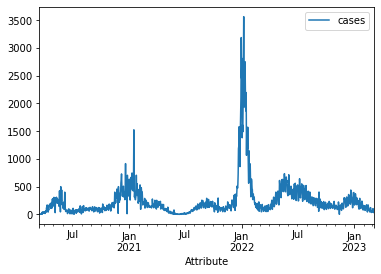

In [7]:
district_cases[district_cases.District=='Fairfax'].plot(x='Attribute',y='cases')

In [8]:
color_dict = dict({'Increase':'red',
                   'Plateau':'#2b8cbe',
                   'Decrease': 'green',
                   'Below Detection': 'grey',
                   'No Trend Available': 'grey'})

In [39]:
# add sewershed name mapping
vdh_df = trend_df.merge(WWS_key, left_on='Sewershed', right_on='Sewershed')
# add district mapping
vdh_df = vdh_df.merge(district_key, left_on='WWS', right_on='WWS')


vdh_swrshd_pop = vdh_df.groupby(['Sewershed', 'Attribute'])['Intersect_Pop'].sum().reset_index()
vdh_swrshd_pop.columns = ['Sewershed', 'Attribute', 'total_pop']
vdh_df = vdh_df.merge(vdh_swrshd_pop, how='left', left_on=['Sewershed', 'Attribute'], right_on=['Sewershed', 'Attribute'])

# add case data
vdh_df = vdh_df.merge(district_cases, how='right', left_on=['District', 'Attribute'], right_on=['District', 'Attribute'])
# add combined covid cases to db and adjust for cross-district
vdh_df['case_frac'] = vdh_df['Fraction'] * vdh_df['cases']
# vdh_df = vdh_df.dropna()

# combine case fractions
case_frac_adj = vdh_df.groupby(['Sewershed', 'Attribute'])['case_frac'].sum().reset_index()
case_frac_adj.columns = ['Sewershed', 'Attribute', 'case_frac_tot']
vdh_df = vdh_df.merge(case_frac_adj, left_on=['Sewershed', 'Attribute'], right_on=['Sewershed', 'Attribute'])

# vdh_df

# add hosp data
vdh_df = vdh_df.merge(county_hosp_data_adj, how='right', left_on=['District', 'Attribute'], right_on=['District', 'Attribute'])
# add combined covid cases to db and adjust for cross-district
vdh_df['hosp_frac'] = vdh_df['Fraction'] * vdh_df['hosps']
# vdh_df

# # combine case fractions
hosp_frac_adj = vdh_df.groupby(['Sewershed', 'Attribute'])['hosp_frac'].sum().reset_index()
hosp_frac_adj
hosp_frac_adj.columns = ['Sewershed', 'Attribute', 'hosp_frac_tot']
vdh_df = vdh_df.merge(hosp_frac_adj, left_on=['Sewershed', 'Attribute'], right_on=['Sewershed', 'Attribute'])



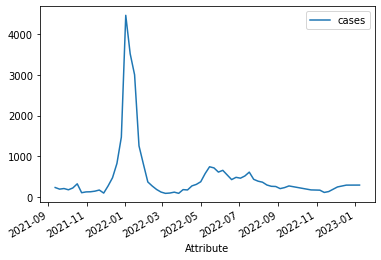

In [10]:
vdh_df[vdh_df.Sewershed=="Alexandria Renew"].groupby(['Sewershed','Attribute'],as_index=False).sum().plot(x='Attribute',y='cases')


In [45]:
sdf=vdh_df.groupby(['Sewershed','Attribute'],as_index=False).sum()[['Sewershed','Attribute','case_frac_tot','hosp_frac_tot']]

In [46]:
sdf[sdf.Sewershed=='Alexandria Renew']

,Sewershed,Attribute,case_frac_tot,hosp_frac_tot
0,Alexandria Renew,2021-09-12,290.893369,281.321409
1,Alexandria Renew,2021-09-19,278.821385,242.134862
2,Alexandria Renew,2021-09-26,269.173209,300.433250
3,Alexandria Renew,2021-10-03,235.105008,252.188016
4,Alexandria Renew,2021-10-10,287.851482,262.241169
5,Alexandria Renew,2021-10-17,505.177116,186.704828
6,Alexandria Renew,2021-10-24,114.165726,141.754488
7,Alexandria Renew,2021-10-31,157.779049,143.520029
8,Alexandria Renew,2021-11-07,145.226404,45.508642
9,Alexandria Renew,2021-11-14,189.655417,71.283097


In [44]:
sdf=sdf.merge(load_df,on=['Sewershed','Attribute'],how='left')

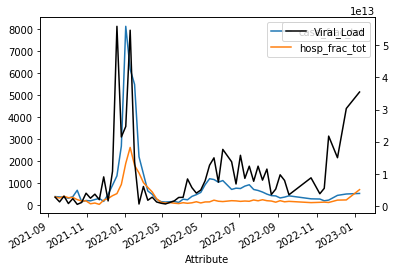

In [30]:
_,ax=plt.subplots()
sdf[sdf.Sewershed=='Alexandria Renew'].plot(x='Attribute',y='case_frac_tot',ax=ax)
sdf[sdf.Sewershed=='Alexandria Renew'].plot(x='Attribute',y='hosp_frac_tot',ax=ax)

ax2=ax.twinx()
sdf[sdf.Sewershed=='Alexandria Renew'].plot(x='Attribute',y='Viral_Load',ax=ax2,color='k')

In [32]:
sdf.to_csv('input/ww_cases_hosp.csv',index=None)

In [37]:
vdh_df[vdh_df.Sewershed=='Alexandria Renew']

,Sewershed,Attribute,Trends,WWS,District,Intersect_Pop,Fraction,total_pop,cases,case_frac,case_frac_tot,hosps,hosp_frac,hosp_frac_tot
0,Alexandria Renew,2021-09-12,No Trend Available,Alexandria Renew Enterprises,Alexandria,149200,0.440237,338908,36.0,15.848549,96.964456,30.0,13.207124,93.773803
1,Alexandria Renew,2021-09-12,No Trend Available,Alexandria Renew Enterprises,Arlington,170,0.000502,338908,46.0,0.023074,96.964456,66.0,0.033106,93.773803
2,Alexandria Renew,2021-09-12,No Trend Available,Alexandria Renew Enterprises,Fairfax,189538,0.559261,338908,145.0,81.092833,96.964456,144.0,80.533572,93.773803
3,Alexandria Renew,2021-09-12,No Trend Available,Alexandria Renew Enterprises,OutsideVA,0,0.000000,338908,NaN,NaN,96.964456,NaN,NaN,93.773803
4,Alexandria Renew,2021-09-19,Decrease,Alexandria Renew Enterprises,Alexandria,149200,0.440237,338908,18.0,7.924274,92.940462,27.0,11.886412,80.711621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,Alexandria Renew,2022-12-18,Plateau,Alexandria Renew Enterprises,OutsideVA,0,0.000000,338908,NaN,NaN,126.214867,NaN,NaN,58.862405
236,Alexandria Renew,2023-01-08,Increase,Alexandria Renew Enterprises,Alexandria,149200,0.440237,338908,33.0,14.527836,132.553460,38.0,16.729024,175.587215
237,Alexandria Renew,2023-01-08,Increase,Alexandria Renew Enterprises,Arlington,170,0.000502,338908,43.0,0.021569,132.553460,56.0,0.028090,175.587215
238,Alexandria Renew,2023-01-08,Increase,Alexandria Renew Enterprises,Fairfax,189538,0.559261,338908,211.0,118.004054,132.553460,284.0,158.830101,175.587215


In [2]:
df=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/opioids_url/Sewershed_PCR_Conc.csv',date_parser=True)
df.sample_collect_date=pd.to_datetime(df.sample_collect_date)
df.test_result_date=pd.to_datetime(df.test_result_date)
# doub_sites=df[(df.sample_collect_date>='2023-08-12')&(df.test_result_date>='2023-08-22')].wwtp_name.unique()
# df[(df.sample_collect_date>='2023-08-05')&(df.sample_collect_date<='2023-08-11')&(df.wwtp_name.isin(doub_sites))]

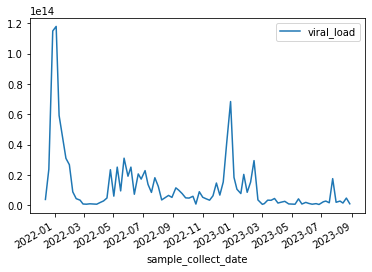

In [7]:
df[df.population_served==530848].plot(x='sample_collect_date',y='viral_load')

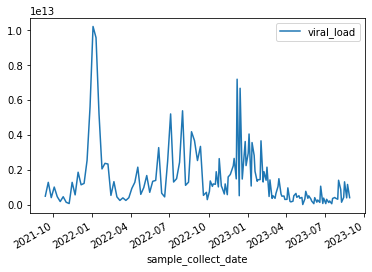

In [19]:
df[df.sewershed=='MooresCreek'].plot(x='sample_collect_date',y='viral_load')

In [16]:
import epiweeks as epi

In [242]:
def conv_epiweek(x):
    week=Week.fromdate(pd.to_datetime(x))
    return str(week.year)+'EW'+'{:02}'.format(week.week)

In [243]:
df.loc[:,'EW']=df.sample_collect_date.apply(lambda x: conv_epiweek(x))

In [244]:
double_ww_dict={}

In [245]:
for i in range(10,34):
    ew='2023EW'+str(i)
    a=df[df.EW==ew][['wwtp_name']]
    sites=list(a[a.duplicated()]['wwtp_name'].values)
    double_ww_dict[ew]=sites

In [246]:
set.symmetric_difference(set([1,2,3,4]),set([1,2,3,4,5]))

{5}

In [247]:
set.symmetric_difference(set(double_ww_dict['2023EW23']),set(double_ww_dict['2023EW24']))

set()

In [248]:
ddf=df[(df.EW>='2023EW10')&(df.wwtp_name.isin(double_ww_dict['2023EW30']))]

Text(0, 0.5, 'VL')

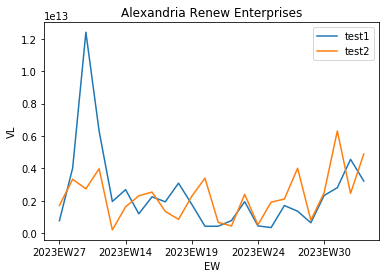

In [303]:
_,ax=plt.subplots()
l='Alexandria Renew Enterprises'
temp[(temp.wwtp_name==l)&(temp.res=='test1')][['EW','viral_load']].plot(x='EW',y='viral_load',ax=ax,label='test1')
temp[(temp.wwtp_name==l)&(temp.res=='test2')][['EW','viral_load']].plot(x='EW',y='viral_load',ax=ax,label='test2')
ax.set_title(l)
ax.set_ylabel('VL')

In [261]:
qdf=pd.DataFrame()
for l in ddf.wwtp_name.unique():
    try:
        temp_data=ddf[ddf.wwtp_name==l][['EW','wwtp_name','sample_collect_date','test_result_date','viral_load']]
        quins=pd.qcut(temp_data['viral_load'],q=5,labels=False)
        temp_data.loc[:,'quin_levels']=quins
        qdf=qdf.append(temp_data)
    except:
        print(l)
qdf.loc[:,'quin_levels']=qdf['quin_levels']+1  

Low Moor Wastewater Treatment Plant


In [283]:
df[(df.EW=='2023EW20')&(df.wwtp_name=='Alexandria Renew Enterprises')]

,sample_id,wwtp_name,sewershed,population_served,sample_type,sample_matrix,sample_collect_date,sample_collect_time,flow_rate,test_result_date,pcr_target_avg_conc,pcr_target_below_lod,lod_sewage,rec_eff_percent,viral_load,EW
2695,NaN,Alexandria Renew Enterprises,ARenew,300000,24-hr flow-weighted composite,post grit removal,2023-05-15,7:00,34.8,2023-05-18,13586.1875,False,6200,4.27,1.790000e+12,2023EW20
2724,NaN,Alexandria Renew Enterprises,ARenew,300000,24-hr flow-weighted composite,post-grit removal,2023-05-17,7:00,35.0,2023-05-24,25682.9875,False,6200,4.39,3.400000e+12,2023EW20


In [263]:
temp1=qdf.groupby(['EW','wwtp_name'])['sample_collect_date'].agg([min]).reset_index().rename(columns={'min':'sample_collect_date'})
temp1.loc[:,'res']='test1'
temp2=qdf.groupby(['EW','wwtp_name'])['sample_collect_date'].agg([max]).reset_index().rename(columns={'max':'sample_collect_date'})
temp2.loc[:,'res']='test2'

In [264]:
temp=temp1.append(temp2)

In [265]:
qdf.shape

(565, 6)

In [266]:
temp[(temp.EW=='2023EW21')&(temp.wwtp_name=='Alexandria Renew Enterprises')]

,EW,wwtp_name,sample_collect_date,res
129,2023EW21,Alexandria Renew Enterprises,2023-05-22,test1
129,2023EW21,Alexandria Renew Enterprises,2023-05-24,test2


In [267]:
temp=temp.merge(qdf)

In [270]:
ptemp=temp.pivot(index=['EW','wwtp_name'],columns='res',values='quin_levels')

(5.0, 0.0)

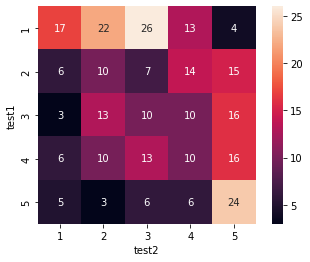

In [287]:
_,ax=plt.subplots()
sns.heatmap(cm,square=True, annot=True,ax=ax)
wid=ax.get_ylim()
ax.set_ylim(wid[0]+0.5, wid[1]-0.5)

In [276]:
cm

test2,1,2,3,4,5
test1,,,,,
1,17,22,26,13,4
2,6,10,7,14,15
3,3,13,10,10,16
4,6,10,13,10,16
5,5,3,6,6,24


In [272]:
cm=pd.crosstab(ptemp['test1'],ptemp['test2'])

In [277]:
ptemp=ptemp.reset_index()

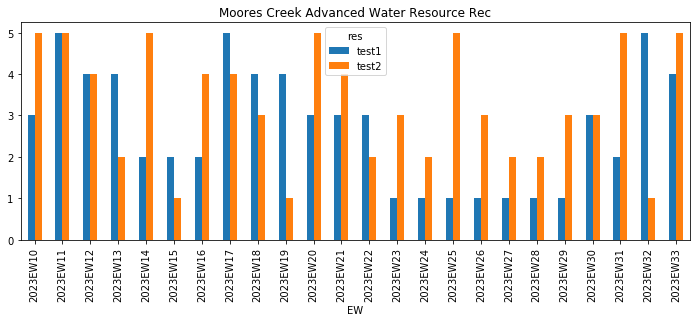

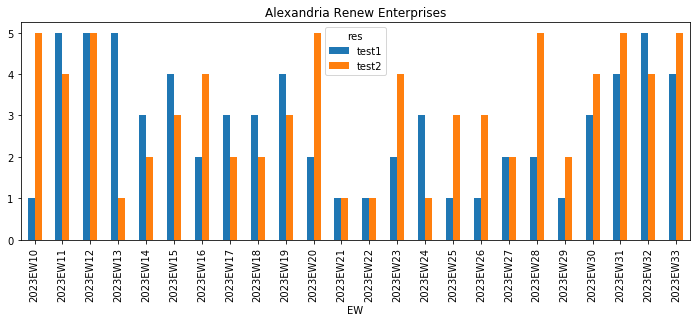

In [291]:
for l in ['Moores Creek Advanced Water Resource Rec', 'Alexandria Renew Enterprises']:
    _,ax=plt.subplots(figsize=(12,4))
    ptemp[ptemp.wwtp_name==l].plot(x='EW',y=['test1','test2'],kind='bar',ax=ax)
    ax.set_title(l)

In [212]:
qdf[(qdf.EW=='2023EW29')&(qdf.wwtp_name=='Alexandria Renew Enterprises')]

,EW,wwtp_name,sample_collect_date,test_result_date,viral_load,quin_levels
3133,2023EW29,Alexandria Renew Enterprises,2023-07-17,2023-07-24,6.460000e+11,0
3163,2023EW29,Alexandria Renew Enterprises,2023-07-19,2023-07-25,8.050000e+11,1


In [230]:
mdf=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/county_mappings/District_to_WWS.csv')

In [238]:
mdf.groupby(['District']).sum().sort_values(by='Intersect_Pop',ascending=False).to_csv('distct_pop.csv')

In [35]:
ls -lt /project/biocomplexity/COVID-19_commons/data/VDH_wastewater/processed_data/case/sewershed/case_agg_latest.csv

-rw-rw---- 1 bh3an nssac_covid19 180633 Aug 29 11:36 /project/biocomplexity/COVID-19_commons/data/VDH_wastewater/processed_data/case/sewershed/case_agg_latest.csv


In [2]:
wdf=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/processed_data/wastewater/sewershed/ww_agg_latest.csv')
wdf.time_value=pd.to_datetime(wdf.time_value)
wdf=wdf.drop(['Unnamed: 0'],axis=1)
cdf=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/processed_data/case/sewershed/case_agg_latest.csv')
cdf.time_value=pd.to_datetime(cdf.time_value)
cdf=cdf.drop(['Unnamed: 0'],axis=1)

In [5]:
ls -lt /project/biocomplexity/COVID-19_commons/data/VDH_wastewater/processed_data/hosp/sewershed/hosp_agg_latest.csv

-rw-rw---- 1 bh3an nssac_covid19 149182 Aug 15 11:51 /project/biocomplexity/COVID-19_commons/data/VDH_wastewater/processed_data/hosp/sewershed/hosp_agg_latest.csv


In [3]:
locs=wdf.geo_value.unique()
for l in locs:
    wtemp=wdf[wdf.geo_value==l]
    ctemp=cdf[cdf.geo_value==l]
    # ctemp.loc[:,'geo_value']=ctemp['geo_value'].map({'MooresCreek':'Moores Creek'})
    wtemp=wtemp.merge(ctemp,on=['geo_value','time_value','geo_res'])
    wtemp=wtemp.set_index('time_value')
    wtemp.to_csv('/project/biocomplexity/aniadiga/data_dump/waste_water/ww_cases_{}.csv'.format(l))

In [15]:
# hdf=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/processed_data/hosp/sewershed/hosp_agg_latest.csv')

In [7]:
l='Blacksburg'
pd.read_csv('/project/biocomplexity/aniadiga/data_dump/waste_water/ww_cases_{}.csv'.format(l))

,time_value,geo_value,viral_load,geo_res,BOW_cases
0,2021-09-12,Blacksburg,1.501905e+12,sewershed,65
1,2021-09-19,Blacksburg,4.597383e+11,sewershed,40
2,2021-09-26,Blacksburg,8.365500e+11,sewershed,43
3,2021-10-03,Blacksburg,4.833072e+11,sewershed,25
4,2021-10-10,Blacksburg,1.280766e+11,sewershed,15
...,...,...,...,...,...
98,2023-07-30,Blacksburg,4.095000e+11,sewershed,6
99,2023-08-06,Blacksburg,4.458000e+11,sewershed,16
100,2023-08-13,Blacksburg,3.397500e+11,sewershed,12
101,2023-08-20,Blacksburg,1.003500e+12,sewershed,8


In [19]:
mkdir /project/biocomplexity/aniadiga/data_dump/waste_water

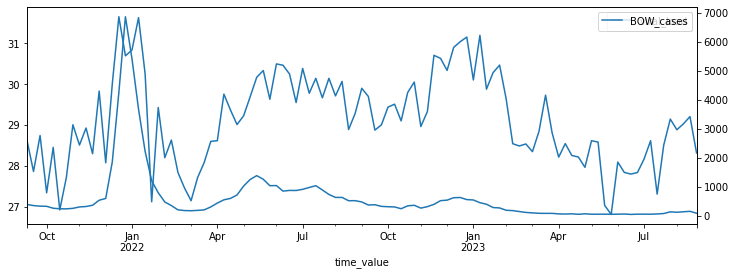

In [16]:
fig,ax=plt.subplots(figsize=(12,4))
np.log(wtemp[['viral_load']]).plot(ax=ax)
ax2=ax.twinx()
wtemp[['BOW_cases']].plot(ax=ax2)

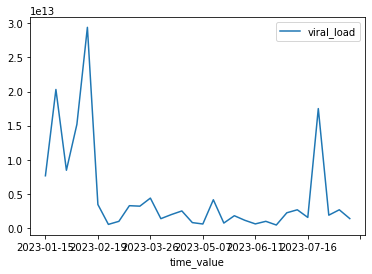

In [30]:
df[df.geo_value=='HRSD_ATCE'].plot(x='time_value',y='viral_load')

In [122]:
hospss=pd.read_csv('/project/biocomplexity/aniadiga/work/IBS/csv/sewersheds_with_hc_and_hosp.csv')

KeyError: "None of [DatetimeIndex(['2021-09-12', '2021-09-19', '2021-09-26', '2021-10-03',\n               '2021-10-10', '2021-10-17', '2021-10-24', '2021-10-31',\n               '2021-11-07', '2021-11-14',\n               ...\n               '2023-06-25', '2023-07-02', '2023-07-09', '2023-07-16',\n               '2023-07-23', '2023-07-30', '2023-08-06', '2023-08-13',\n               '2023-08-20', '2023-08-27'],\n              dtype='datetime64[ns]', name='time_value', length=103, freq=None)] are in the [columns]"

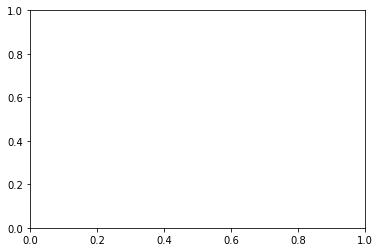

In [142]:
ax=wtemp[['viral_load']].plot.scatter(x=wtemp.index,y=wtemp['viral_load'].values)
wtemp[['viral_load']].rolling(3,center=True).mean().plot(ax=ax)

In [143]:
wtemp.index

DatetimeIndex(['2021-09-12', '2021-09-19', '2021-09-26', '2021-10-03',
               '2021-10-10', '2021-10-17', '2021-10-24', '2021-10-31',
               '2021-11-07', '2021-11-14',
               ...
               '2023-06-25', '2023-07-02', '2023-07-09', '2023-07-16',
               '2023-07-23', '2023-07-30', '2023-08-06', '2023-08-13',
               '2023-08-20', '2023-08-27'],
              dtype='datetime64[ns]', name='time_value', length=103, freq=None)

In [9]:
hfdf=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/HealthData_gov/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_Facility.csv')

/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
hfdf=hfdf[hfdf.state=='VA']

In [14]:
hfdf[hfdf.hospital_name=='UNIVERSITY OF VIRGINIA MEDICAL CENTER'].columns

Index(['hospital_pk', 'collection_week', 'state', 'ccn', 'hospital_name',
       'address', 'city', 'zip', 'hospital_subtype', 'fips_code',
       ...
       'previous_day_admission_adult_covid_suspected_50',
       'previous_day_admission_adult_covid_suspected_60',
       'total_patients_hospitalized_confirmed_influenza_and_covid_7_day_avg',
       'total_patients_hospitalized_confirmed_influenza_and_covid_7_day_sum',
       'previous_week_personnel_covid_vaccinated_doses_administered_7_day',
       'total_personnel_covid_vaccinated_doses_none_7_day',
       'total_personnel_covid_vaccinated_doses_one_7_day',
       'total_personnel_covid_vaccinated_doses_all_7_day',
       'previous_week_patients_covid_vaccinated_doses_one_7_day',
       'previous_week_patients_covid_vaccinated_doses_all_7_day'],
      dtype='object', length=129)

In [15]:
hdf=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/COVIDCast/dsew-cpr_confirmed_admissions_covid_1d_7dav_county.csv')

In [19]:
temp=hdf[hdf.geo_value==51003]

In [22]:
temp.loc[:,'time_value']=pd.to_datetime(temp.time_value)

/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
